# Assignment 3 on Natural Language Processing

## Date : 30th Sept, 2020

### Instructor : Prof. Sudeshna Sarkar

### Teaching Assistants : Alapan Kuila, Aniruddha Roy, Anusha Potnuru, Uppada Vishnu

The central idea of this assignment is to use Naive Bayes classifier and LSTM based classifier and compare the models by accuracy on IMDB dataset.



Please submit with outputs. 

In [1]:
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.metrics import classification_report

In [2]:
from nltk.corpus import stopwords
eng_stopwords = stopwords.words('english')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
porter_stemmer = PorterStemmer()
snowball_stemmer = SnowballStemmer(language='english')

In [3]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
#Load the IMDB dataset. You can load it using pandas as dataframe
df=pd.read_csv('IMDB Dataset.csv')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Preprocessing
PrePrecessing that needs to be done on lower cased corpus

1. Remove html tags
2. Remove URLS
3. Remove non alphanumeric character
4. Remove Stopwords
5. Perform stemming and lemmatization

You can use regex from re. 

In [5]:
# preprocessing re expressions to remove 
res = r'<.*?>|http\S+|www\S+|[^a-zA-Z\s]|\n' # regular expression for preprocessing the input
reprocess = re.compile(res)
df['review'] = df['review'].apply(lambda x: re.sub(reprocess, '', x.lower()))

In [6]:
# removing stopwords and applying stemming and lemmaitization
# takes 1-2 mins
df['review'] = df['review'].apply(lambda x: snowball_stemmer.stem(' '.join([w for w in word_tokenize(x) if w not in eng_stopwords])))

In [7]:
# final preprocessed data 'review' column
df['review'][0]

'one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle cl

In [8]:
# Print Statistics of Data like avg length of sentence , proposition of data w.r.t class labels
grp = df.groupby(['sentiment'])
pos_review_length = (grp.get_group('positive'))['review'].apply(lambda x: len(x.split(' ')))
neg_review_length = (grp.get_group('negative'))['review'].apply(lambda x: len(x.split(' ')))
df['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [9]:
print('Positive reviews\n mean: {}\n standard deviation: {}\n'.format(pos_review_length.mean(),pos_review_length.var()**0.5))
print('Negative reviews\n mean: {}\n standard deviation: {}'.format(neg_review_length.mean(),neg_review_length.var()**0.5))

Positive reviews
 mean: 119.92256
 standard deviation: 92.96069271827898

Negative reviews
 mean: 117.22948
 standard deviation: 85.34994530435395


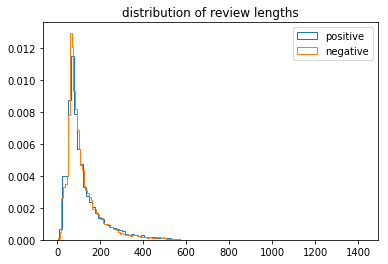

Nearly identical distribution


In [10]:
plt.hist(pos_review_length,bins=100,density=1,histtype='step')
plt.title('distribution of postive review length')
plt.hist(neg_review_length,bins=100,density=1,histtype='step')
plt.title('distribution of review lengths')
plt.legend(['positive','negative'])
plt.show()
print("Nearly identical distribution")

# Naive Bayes classifier

In [11]:
# get reviews column from df
reviews = df['review']

# get labels column from df
labels =df['sentiment']

In [12]:
# Use label encoder to encode labels. Convert to 0/1
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)

print(encoder.classes_)

['negative' 'positive']


In [13]:
# Split the data into train and test (80% - 20%). 
# Use stratify in train_test_split so that both train and test have similar ratio of positive and negative samples.

train_sentences, test_sentences, train_labels, test_labels = train_test_split(reviews, 
                                                                               encoded_labels, 
                                                                               test_size=0.20, 
                                                                               random_state=3141, 
                                                                               stratify=labels)

Here there are two approaches possible for building vocabulary for the naive Bayes.
1. Take the whole data (train + test) to build the vocab. In this way while testing there is no word which will be out of vocabulary.
2. Take the train data to build vocab. In this case, some words from the test set may not be in vocab and hence one needs to perform smoothing so that one the probability term is not zero.
 
You are supposed to go by the 2nd approach.
 
Also building vocab by taking all words in the train set is memory intensive, hence you are required to build vocab by choosing the top 2000 - 3000 frequent words in the training corpus.

> $ P(x_i | w_j) = \frac{ N_{x_i,w_j}\, +\, \alpha }{ N_{w_j}\, +\, \alpha*d} $


$N_{x_i,w_j}$ : Number of times feature $x_i$ appears in samples of class $w_j$

$N_{w_j}$ : Total count of features in class $w_j$

$\alpha$ : Parameter for additive smoothing. Here consider $\alpha$ = 1

$d$ : Dimentionality of the feature vector  $x = [x_1,x_2,...,x_d]$. In our case its the vocab size.






In [14]:
class Naive_Bayes(object):
    """
    Class to store the Naive Bayes Model
    """
    
    def __init__(self, train_sent, train_lab, alpha=1, vocab_size=3000):
        
        self.alpha = alpha
        self.vocab_size = vocab_size

        self.train_sent = train_sent.reset_index(drop=True)
        self.train_lab = train_lab 

        self.pos_sent = self.train_sent[np.argwhere(self.train_lab).squeeze().tolist()]
        self.neg_sent = self.train_sent.drop(np.argwhere(self.train_lab).squeeze().tolist())

        # class probabilites
        self.P_pos = len(self.pos_sent)/len(self.train_lab)
        self.P_neg = len(self.neg_sent)/len(self.train_lab)

        # training data to build vocab and only take top 'vocab_size' number of words
        self.vectorizer = CountVectorizer(max_features = self.vocab_size)
        self.vec = self.vectorizer.fit_transform(self.train_sent) 
        self.vocab = self.vectorizer.get_feature_names()
        
        # count of words in positive and negative classes by sentences/reviews
        self.vec_pos = self.vectorizer.transform(self.pos_sent)
        self.vec_neg = self.vectorizer.transform(self.neg_sent)
        self.total_pos = self.vec_pos.sum()
        self.total_neg = self.vec_neg.sum()
        
        # calculating the log probs of all the words in vocab
        self.word_log_prob_dict = {0:{},1:{}}
        self.__set_word_log_prob__()
        
    # returns log probability of word given sentiment class
    # Using laplace smoothing for words in test set not present in vocab of train set
    def __get_word_log_prob__(self, word, sentiment):  
        if sentiment == 1:
            count_word = self.vec_pos[:, self.vocab.index(word)].sum() if word in self.vocab else 0

            return np.log((count_word + self.alpha)/(self.total_pos + self.alpha*self.vocab_size))  
        elif sentiment == 0:
            count_word = self.vec_neg[:, self.vocab.index(word)].sum() if word in self.vocab else 0 

            return np.log((count_word + self.alpha)/(self.total_pos + self.alpha*self.vocab_size))
        
    def __set_word_log_prob__(self):
        for word in self.vocab :
            self.word_log_prob_dict[0][word]=self.__get_word_log_prob__(word,0)
            self.word_log_prob_dict[1][word]=self.__get_word_log_prob__(word,1)
    
    def __predict_single__(self, sentence): 
        log_prob_pos = np.log(self.P_pos)
        log_prob_neg = np.log(self.P_neg)

        for word in word_tokenize(sentence):
            ## if word is not found in the vocab then continue
            if word not in self.vocab:
                continue
            log_prob_pos += self.word_log_prob_dict[1][word]
            log_prob_neg += self.word_log_prob_dict[0][word]

        return 1 if log_prob_pos > log_prob_neg else 0
    
    def predict(self,sentences):
        sentences = list(sentences)
        predictions = []
        for sentence in sentences:
            predictions.append(self.__predict_single__(sentence))
        return np.array(predictions)

In [15]:
# building the model

NBclassifier = Naive_Bayes(train_sentences, train_labels)

In [16]:
# predictions on testing data

test_predictions = NBclassifier.predict(test_sentences.reset_index(drop=True))

In [17]:
print(classification_report(test_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      5000
           1       0.86      0.82      0.84      5000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



# *LSTM* based Classifier

Use the above train and test splits.

In [18]:
# Hyperparameters of the model
vocab_size = 3000 # choose based on statistics
oov_tok = '<OOK>'
embedding_dim = 100
max_length = 300 # choose based on statistics, for example 150 to 200
padding_type='post'
trunc_type='post'

In [19]:
# tokenize sentences
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length)

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length)

In [20]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dense(24, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 100)          300000    
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 24)                3096      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 387,601
Trainable params: 387,601
Non-trainable params: 0
_________________________________________________________________


In [21]:
num_epochs = 5
history = model.fit(train_padded, train_labels, 
                    epochs=num_epochs, verbose=1, 
                    validation_split=0.1)

Epoch 1/5
1125/1125 [==============================] - 123s 109ms/step - loss: 0.4320 - accuracy: 0.8037 - val_loss: 0.3607 - val_accuracy: 0.8493
Epoch 2/5
1125/1125 [==============================] - 126s 112ms/step - loss: 0.3162 - accuracy: 0.8739 - val_loss: 0.3223 - val_accuracy: 0.8640
Epoch 3/5
1125/1125 [==============================] - 124s 110ms/step - loss: 0.2673 - accuracy: 0.8947 - val_loss: 0.3319 - val_accuracy: 0.8553
Epoch 4/5
1125/1125 [==============================] - 124s 111ms/step - loss: 0.2355 - accuracy: 0.9086 - val_loss: 0.3154 - val_accuracy: 0.8767
Epoch 5/5
1125/1125 [==============================] - 125s 111ms/step - loss: 0.2444 - accuracy: 0.9034 - val_loss: 0.3464 - val_accuracy: 0.8593


In [22]:
# Calculate accuracy on Test data

# Get probabilities
prediction_probs = model.predict(test_padded)


In [23]:
# Get labels based on probability 1 if p>= 0.5 else 0
test_predicted = np.where(prediction_probs >= 0.5, 1, 0)

# Accuracy : one can use classification_report from sklearn
print(classification_report(test_labels, test_predicted))

              precision    recall  f1-score   support

           0       0.83      0.93      0.87      5000
           1       0.92      0.81      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



## Get predictions for random examples

In [24]:
# reviews on which we need to predict
sentence = ["The movie was very touching and heart whelming", 
            "I have never seen a terrible movie like this", 
            "the movie plot is terrible but it had good acting"]

# convert to a sequence
sequences = tokenizer.texts_to_sequences(sentence)

# pad the sequence
padded =  pad_sequences(sequences, padding='post', maxlen=max_length)

# Get probabilities
predicts = model.predict(padded)

# Get labels based on probability 1 if p>= 0.5 else 0
sentiments = np.where(predicts >= 0.5, 1, 0)

In [25]:
for i, sent in enumerate(sentence):
    print('For','`'+sent+'`','Predicted Sentiment is {}\n'.format('Positive' if sentiments[i][0] else 'Negative'))

For `The movie was very touching and heart whelming` Predicted Sentiment is Positive

For `I have never seen a terrible movie like this` Predicted Sentiment is Negative

For `the movie plot is terrible but it had good acting` Predicted Sentiment is Negative

